In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_conv_3_VGG_DO_075_DO(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, padding='same', 
                      activation='relu', input_shape=input_shape)) 
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, padding='same', 
                  activation='relu')) 
#     model.add(BatchNormalization())
#     model.add(MaxPooling1D(pool_size=3, strides=3))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same', 
                          activation='relu'))
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same', 
                          activation='relu'))         
#         model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.75))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_conv_3_VGG_DO_075_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 64)         12352     
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)                (None, 16)                16384016  
Total params: 16,396,624
Trainable params: 16,396,624
Non-trainable params: 0
_________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_30 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 5333, 64)          12352     
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 5333, 64)          12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_75 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 5333, 64)          12352     
_________________________________________________________________
conv1d_77 (Conv1D)           (None, 5333, 64)          12352     
__________

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5160 - acc: 0.1722
Epoch 00001: val_loss improved from inf to 1.75446, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_6_conv_checkpoint/001-1.7545.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 2.5159 - acc: 0.1723 - val_loss: 1.7545 - val_acc: 0.4570
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6667 - acc: 0.4482
Epoch 00002: val_loss improved from 1.75446 to 1.39848, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_6_conv_checkpoint/002-1.3985.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 1.6667 - acc: 

36800/36805 [============================>.] - ETA: 0s - loss: 0.4282 - acc: 0.8711
Epoch 00021: val_loss did not improve from 0.36754
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.4282 - acc: 0.8711 - val_loss: 0.3775 - val_acc: 0.8998
Epoch 22/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4136 - acc: 0.8754
Epoch 00022: val_loss did not improve from 0.36754
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.4138 - acc: 0.8753 - val_loss: 0.3978 - val_acc: 0.8880
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4038 - acc: 0.8801
Epoch 00023: val_loss did not improve from 0.36754
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.4038 - acc: 0.8802 - val_loss: 0.3901 - val_acc: 0.8887
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3851 - acc: 0.8843
Epoch 00024: val_loss did not improve from 0.36754
36805/36805 [========================

Epoch 47/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2128 - acc: 0.9320
Epoch 00047: val_loss did not improve from 0.27883
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.2128 - acc: 0.9320 - val_loss: 0.2964 - val_acc: 0.9297
Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2146 - acc: 0.9304
Epoch 00048: val_loss did not improve from 0.27883
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.2145 - acc: 0.9304 - val_loss: 0.2814 - val_acc: 0.9338
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2021 - acc: 0.9357
Epoch 00049: val_loss did not improve from 0.27883
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.2021 - acc: 0.9357 - val_loss: 0.3127 - val_acc: 0.9234
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2039 - acc: 0.9346
Epoch 00050: val_loss improved from 0.27883 to 0.27123, saving model to mod

Epoch 76/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1301 - acc: 0.9567
Epoch 00076: val_loss did not improve from 0.25766
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1301 - acc: 0.9567 - val_loss: 0.2923 - val_acc: 0.9331
Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1355 - acc: 0.9562
Epoch 00077: val_loss did not improve from 0.25766
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1355 - acc: 0.9562 - val_loss: 0.3144 - val_acc: 0.9369
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1268 - acc: 0.9576
Epoch 00078: val_loss did not improve from 0.25766
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1268 - acc: 0.9576 - val_loss: 0.2824 - val_acc: 0.9387
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1282 - acc: 0.9571
Epoch 00079: val_loss did not improve from 0.25766
36805/36805 [===========

Epoch 106/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0928 - acc: 0.9686
Epoch 00106: val_loss did not improve from 0.25766
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0928 - acc: 0.9686 - val_loss: 0.2753 - val_acc: 0.9394
Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0945 - acc: 0.9695
Epoch 00107: val_loss did not improve from 0.25766
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0945 - acc: 0.9695 - val_loss: 0.3468 - val_acc: 0.9313
Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0925 - acc: 0.9692
Epoch 00108: val_loss did not improve from 0.25766
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0925 - acc: 0.9691 - val_loss: 0.3218 - val_acc: 0.9348

1D_CNN_custom_conv_3_VGG_DO_075_DO_6_conv Model


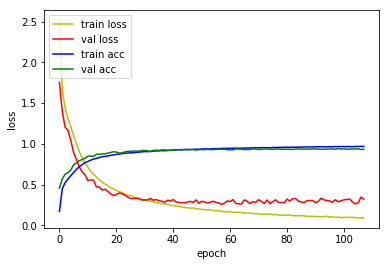

4815/4815 [==============================] - 5s 953us/sample - loss: 0.3132 - acc: 0.9140
Loss: 0.3132208975676064 Accuracy: 0.9140187

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6841 - acc: 0.0955
Epoch 00001: val_loss improved from inf to 2.46401, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_7_conv_checkpoint/001-2.4640.hdf5
36805/36805 [==============================] - 93s 3ms/sample - loss: 2.6840 - acc: 0.0955 - val_loss: 2.4640 - val_acc: 0.1992
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0600 - acc: 0.3188
Epoch 00002: val_loss improved from 2.46401 to 1.46965, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_7_conv_checkpoint/002-1.4696.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 2.0600 - acc: 0.3188 - val_loss: 1.4696 - val_acc: 0.5365
Epoch 3/500
36800/36805 [============================>.

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3492 - acc: 0.8939
Epoch 00023: val_loss did not improve from 0.25269
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.3492 - acc: 0.8939 - val_loss: 0.2596 - val_acc: 0.9257
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3301 - acc: 0.8992
Epoch 00024: val_loss did not improve from 0.25269
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.3302 - acc: 0.8991 - val_loss: 0.2597 - val_acc: 0.9224
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3178 - acc: 0.9040
Epoch 00025: val_loss improved from 0.25269 to 0.23574, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_7_conv_checkpoint/025-0.2357.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.3178 - acc: 0.9040 - val_loss: 0.2357 - val_acc: 0.9345
Epoch 26/500
36800/36805 [============================>.] - ETA: 

Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1749 - acc: 0.9445
Epoch 00049: val_loss improved from 0.16973 to 0.16293, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_7_conv_checkpoint/049-0.1629.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1749 - acc: 0.9445 - val_loss: 0.1629 - val_acc: 0.9567
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1677 - acc: 0.9461
Epoch 00050: val_loss did not improve from 0.16293
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1677 - acc: 0.9461 - val_loss: 0.1691 - val_acc: 0.9541
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1651 - acc: 0.9481
Epoch 00051: val_loss did not improve from 0.16293
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1651 - acc: 0.9481 - val_loss: 0.1846 - val_acc: 0.9539
Epoch 52/500
36800/36805 [============================>.] - ETA: 

Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1042 - acc: 0.9668
Epoch 00077: val_loss did not improve from 0.14820
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1042 - acc: 0.9669 - val_loss: 0.1839 - val_acc: 0.9592
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1037 - acc: 0.9657
Epoch 00078: val_loss did not improve from 0.14820
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1037 - acc: 0.9657 - val_loss: 0.1631 - val_acc: 0.9609
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1007 - acc: 0.9674
Epoch 00079: val_loss did not improve from 0.14820
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1007 - acc: 0.9674 - val_loss: 0.1555 - val_acc: 0.9632
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0980 - acc: 0.9670
Epoch 00080: val_loss did not improve from 0.14820
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0668 - acc: 0.9772
Epoch 00106: val_loss did not improve from 0.14705
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0667 - acc: 0.9772 - val_loss: 0.1526 - val_acc: 0.9639
Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0671 - acc: 0.9776
Epoch 00107: val_loss did not improve from 0.14705
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0671 - acc: 0.9776 - val_loss: 0.1590 - val_acc: 0.9662
Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0674 - acc: 0.9773
Epoch 00108: val_loss did not improve from 0.14705
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0674 - acc: 0.9773 - val_loss: 0.1819 - val_acc: 0.9620
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0694 - acc: 0.9770
Epoch 00109: val_loss did not improve from 0.14705
36805/36805 [=====================

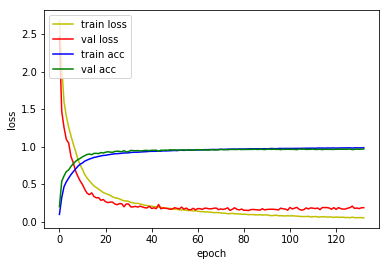

4815/4815 [==============================] - 5s 986us/sample - loss: 0.1763 - acc: 0.9510
Loss: 0.17631158992369597 Accuracy: 0.9509865

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6572 - acc: 0.1121
Epoch 00001: val_loss improved from inf to 2.24626, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_8_conv_checkpoint/001-2.2463.hdf5
36805/36805 [==============================] - 97s 3ms/sample - loss: 2.6571 - acc: 0.1121 - val_loss: 2.2463 - val_acc: 0.3182
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9518 - acc: 0.3585
Epoch 00002: val_loss improved from 2.24626 to 1.29374, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_8_conv_checkpoint/002-1.2937.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 1.9518 - acc: 0.3585 - val_loss: 1.2937 - val_acc: 0.6007
Epoch 3/500
36800/36805 [============================>

36800/36805 [============================>.] - ETA: 0s - loss: 0.2544 - acc: 0.9205
Epoch 00023: val_loss did not improve from 0.17801
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.2544 - acc: 0.9205 - val_loss: 0.1866 - val_acc: 0.9434
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2477 - acc: 0.9238
Epoch 00024: val_loss improved from 0.17801 to 0.17220, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_8_conv_checkpoint/024-0.1722.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.2477 - acc: 0.9238 - val_loss: 0.1722 - val_acc: 0.9476
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2372 - acc: 0.9263
Epoch 00025: val_loss improved from 0.17220 to 0.16398, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_8_conv_checkpoint/025-0.1640.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.2372 - acc: 0.9263 - val_lo

Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1061 - acc: 0.9654
Epoch 00050: val_loss did not improve from 0.10324
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1061 - acc: 0.9654 - val_loss: 0.1077 - val_acc: 0.9693
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1038 - acc: 0.9665
Epoch 00051: val_loss did not improve from 0.10324
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.1038 - acc: 0.9665 - val_loss: 0.1215 - val_acc: 0.9686
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1035 - acc: 0.9664
Epoch 00052: val_loss did not improve from 0.10324
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.1035 - acc: 0.9664 - val_loss: 0.1127 - val_acc: 0.9665
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1007 - acc: 0.9688
Epoch 00053: val_loss improved from 0.10324 to 0.10257, saving model to mod

Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0586 - acc: 0.9803
Epoch 00079: val_loss did not improve from 0.09761
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0586 - acc: 0.9803 - val_loss: 0.1042 - val_acc: 0.9725
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0612 - acc: 0.9804
Epoch 00080: val_loss did not improve from 0.09761
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0612 - acc: 0.9804 - val_loss: 0.1198 - val_acc: 0.9690
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0554 - acc: 0.9818
Epoch 00081: val_loss did not improve from 0.09761
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0554 - acc: 0.9818 - val_loss: 0.1244 - val_acc: 0.9741
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0548 - acc: 0.9821
Epoch 00082: val_loss did not improve from 0.09761
36805/36805 [===========

Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0424 - acc: 0.9868
Epoch 00109: val_loss did not improve from 0.09761
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0424 - acc: 0.9868 - val_loss: 0.1257 - val_acc: 0.9730
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0362 - acc: 0.9881
Epoch 00110: val_loss did not improve from 0.09761
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0362 - acc: 0.9881 - val_loss: 0.1330 - val_acc: 0.9725
Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0349 - acc: 0.9891
Epoch 00111: val_loss did not improve from 0.09761
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0349 - acc: 0.9891 - val_loss: 0.1242 - val_acc: 0.9737
Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0341 - acc: 0.9889
Epoch 00112: val_loss did not improve from 0.09761
36805/36805 [=======

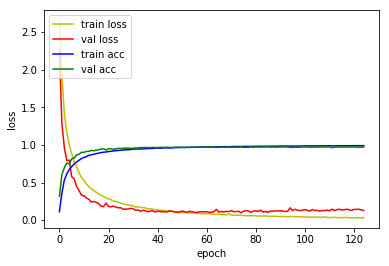

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.1470 - acc: 0.9616
Loss: 0.14699696631142764 Accuracy: 0.9615784

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3951 - acc: 0.2141
Epoch 00001: val_loss improved from inf to 1.65410, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_9_conv_checkpoint/001-1.6541.hdf5
36805/36805 [==============================] - 102s 3ms/sample - loss: 2.3951 - acc: 0.2141 - val_loss: 1.6541 - val_acc: 0.4596
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4471 - acc: 0.5235
Epoch 00002: val_loss improved from 1.65410 to 0.91895, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_9_conv_checkpoint/002-0.9190.hdf5
36805/36805 [==============================] - 92s 2ms/sample - loss: 1.4469 - acc: 0.5235 - val_loss: 0.9190 - val_acc: 0.7098
Epoch 3/500
36800/36805 [============================>.

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1506 - acc: 0.9524
Epoch 00024: val_loss did not improve from 0.13241
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1506 - acc: 0.9524 - val_loss: 0.1422 - val_acc: 0.9599
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1466 - acc: 0.9536
Epoch 00025: val_loss improved from 0.13241 to 0.12905, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_9_conv_checkpoint/025-0.1290.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1466 - acc: 0.9536 - val_loss: 0.1290 - val_acc: 0.9634
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1369 - acc: 0.9572
Epoch 00026: val_loss did not improve from 0.12905
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1369 - acc: 0.9572 - val_loss: 0.1391 - val_acc: 0.9583
Epoch 27/500
36800/36805 [============================>.] - ETA: 

36800/36805 [============================>.] - ETA: 0s - loss: 0.0547 - acc: 0.9817
Epoch 00052: val_loss did not improve from 0.11015
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0547 - acc: 0.9817 - val_loss: 0.1130 - val_acc: 0.9725
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0544 - acc: 0.9825
Epoch 00053: val_loss did not improve from 0.11015
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0544 - acc: 0.9825 - val_loss: 0.1331 - val_acc: 0.9655
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0512 - acc: 0.9826
Epoch 00054: val_loss did not improve from 0.11015
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0512 - acc: 0.9826 - val_loss: 0.1581 - val_acc: 0.9653
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0485 - acc: 0.9844
Epoch 00055: val_loss did not improve from 0.11015
36805/36805 [========================

Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0265 - acc: 0.9914
Epoch 00082: val_loss did not improve from 0.11015
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0265 - acc: 0.9914 - val_loss: 0.1608 - val_acc: 0.9693
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0290 - acc: 0.9909
Epoch 00083: val_loss did not improve from 0.11015
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0290 - acc: 0.9909 - val_loss: 0.1541 - val_acc: 0.9718
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0294 - acc: 0.9905
Epoch 00084: val_loss did not improve from 0.11015
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0294 - acc: 0.9905 - val_loss: 0.1548 - val_acc: 0.9704

1D_CNN_custom_conv_3_VGG_DO_075_DO_9_conv Model


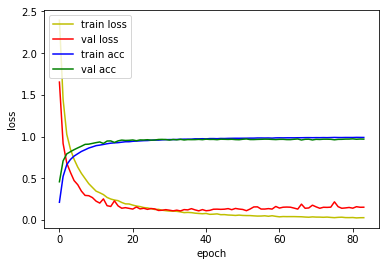

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.1638 - acc: 0.9568
Loss: 0.16382623730809548 Accuracy: 0.95680165



In [9]:
for i in range(6, 10):
    model_name = '1D_CNN_custom_conv_3_VGG_DO_075_DO_{}_conv'.format(i)
    model = build_1d_cnn_custom_conv_3_VGG_DO_075_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)
    
    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [10]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_conv_3_VGG_DO_075_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(1, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_DO_075_DO_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024000)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                16384016  
Total params: 16,396,624
Trainable params: 16,396,624
Non-trainable params: 0
_________________________________________________________________
4815/4815 [==============================] - 3s 540us/sample - loss: 2.0562 - acc

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.6308 - acc: 0.8706
Loss: 0.6307582460088522 Accuracy: 0.8706127

1D_CNN_custom_conv_3_VGG_DO_075_DO_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5333, 64)          0         
_________________________________________________________________
conv1d_4 (Conv1D)         

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.1470 - acc: 0.9616
Loss: 0.14699696631142764 Accuracy: 0.9615784

1D_CNN_custom_conv_3_VGG_DO_075_DO_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_46 (Conv1D)       

In [11]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_conv_3_VGG_DO_075_DO'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(3, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_DO_075_DO_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_96 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
conv1d_97 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_98 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_99 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_100 (Conv1D)          (None, 5333, 64)          12352     
_________________________________________________________________
conv1d_101 (Conv1D)        

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.3734 - acc: 0.9186
Loss: 0.37344957900041115 Accuracy: 0.91858774

1D_CNN_custom_conv_3_VGG_DO_075_DO_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 5333, 64)          0         
_________________________________________________________________
conv1d_16 (Conv1D)      

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2036 - acc: 0.9593
Loss: 0.20364515322298313 Accuracy: 0.9592939
